# Hotel Booking Cancelation
### by Riyan Rafif Edward
## Business Understanding
**Context**

Sebuah hotel yang berlokasi di negara portugal ingin meningkatkan jumlah pemesanan kamar hotel yang mereka miliki. Setelah orang-orang melakukan pemesanan kamar hotel, pihak hotel ingin mengetahui tamu mana yang akan benar-benar menginap di hotel mereka dan tamu yang tidak jadi menginap untuk mengurangi biaya operasional serta efisiensi terhadap kamar hotel yang tersedia.

Target :

0 : Tidak Cancel

1 : Cancel


**Problem Statement**

Dalam konteks bisnis perhotelan, apabila pengunjung melakukan pemesanan kamar maka pihak hotel akan menyiapkan beberapa hal untuk menyambut kedatangan mereka, di antaranya:  
>* Menghubungi pengunjung terkait kapan perkiraan datang ke hotel,
>* Membersihkan, merapikan, dan menyiapkan kamar sesuai pesanan pengunjung,
>* Menyiapkan makanan dan minuman untuk menyambut kedatangan pengunjung,
>* Menolak pengunjung lain yang memesan kamar yang telah dipesan (*booked room*), dan
>* Memberi layanan penjemputan di bandara/stasiun/terminal apabila diperlukan.  

Jika tamu tidak jadi menginap di hotel padahal sudah melakukan booking maka kamar hotel yang sudah di siapkan gagal untuk disewakan dan bisa merugikan,biaya operasional yang dikeluarkan untuk menyambut kedatangan tamu juga akan menjadi sia-sia.

**Goals**

Maka berdasarkan permalahan tersebut, hotel ingin memiliki kemampuan untuk memprediksi kemungkinan seorang tamu akan melakukan cancel booking atau tidak, sehingga dapat memfokuskan kamar hotel untuk di sewakan kembali jika seorang tamu melakukan cancel.

Dan juga, Hotel ingin mengetahui apa faktor yang menyebabkan seorang tamu melakukan cancel ataupun tidak, sehingga mereka dapat membuat rencana yang lebih baik untuk mengurangi tingkat cancel pada tamu.

**Analytic Approach**

Jadi yang akan kita lakukan adalah menganalisa data untuk menentukan pola yang membedakan behavior dari tamu yang melakukan cancel dan tamu yang tidak melakukan cancel. Kemudian kita akan membangun model klasifikasi yang membantu perusahaan untuk dapat memprediksi probabilitas seorang tamu akan melakukan cancel atau tidak.

**Metric Evaluation**
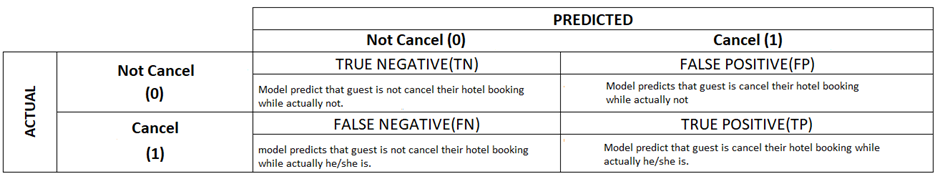

Ada **2 jenis kesalahan** yang mungkin terjadi dalam model ML di studi kasus ini, yaitu:
>* Model memprediksi user akan *cancel booking* (membatalkan pesanan), padahal sebenarnya/realisasinya user tidak membatalkan pesanan. Konsekuensi nya dapat kehilangan tamu yang loyal atau tamu  potensial
>* Model memprediksi user tidak membatalkan pesanan, padahal sebenarnya/realisasinya user *cancel booking* (membatalkan pesanan). Konesekuensi nya karena kerugian kamar batal disewa, dan biaya operasional yang sudah dikeluarkan menjadi sia-sia.

Berdasarkan konsekuensinya, maka sebisa mungkin membuat model yang dapat mengurangi kerugian karena kamar gagal di besan, tetapi dapat membuat tamu yang berpotensi loyal terhadap hotel berkurang. Jadi harus diseimbangkan antara precision dan recall. metrics yang akan kita gunakan adalah f1 Score

**Data Understanding**

Dataset ini berasal dari paper Jurnal Ilmiah berjudul "Hotel booking demand datasets" yang ditulis oleh Nuno Antonio, Ana Almeida, and Luis Nunes for Data in Brief, Volume 22, February 2019. Penjelasan tiap feature/variabel dari Jurnal bisa Anda akses di  https://www.sciencedirect.com/science/article/pii/S2352340918315191

Apabila ingin mengetahui keterangan di setiap kolom, Anda bisa akses ke: https://www.kaggle.com/jessemostipak/hotel-booking-demand/data. 

In [1]:
# library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

# Preprocessing
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model & evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, plot_roc_curve,plot_precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.metrics import roc_auc_score, plot_roc_curve, f1_score

pd.options.display.max_columns = None

In [2]:
# load dataset
hotel=pd.read_csv('hotel_bookings.csv')
hotel.head(6)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# Data Cleaning


In [3]:
hotel.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [4]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
df=hotel.copy()

In [6]:
df.head(6)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [7]:
df[df.duplicated()]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
22,Resort Hotel,0,72,2015,July,27,1,2,4,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,A,A,1,No Deposit,250.0,NaN,0,Transient,84.67,0,1,Check-Out,2015-07-07
43,Resort Hotel,0,70,2015,July,27,2,2,3,2,0.0,0,HB,ROU,Direct,Direct,0,0,0,E,E,0,No Deposit,250.0,NaN,0,Transient,137.00,0,1,Check-Out,2015-07-07
138,Resort Hotel,1,5,2015,July,28,5,1,0,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,240.0,NaN,0,Transient,97.00,0,0,Canceled,2015-07-01
200,Resort Hotel,0,0,2015,July,28,7,0,1,1,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,109.80,0,3,Check-Out,2015-07-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119349,City Hotel,0,186,2017,August,35,31,0,3,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,126.00,0,2,Check-Out,2017-09-03
119352,City Hotel,0,63,2017,August,35,31,0,3,3,0.0,0,BB,SWE,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
119353,City Hotel,0,63,2017,August,35,31,0,3,3,0.0,0,BB,SWE,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
119354,City Hotel,0,63,2017,August,35,31,0,3,3,0.0,0,BB,SWE,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03


terdapat 31.994 row data duplicate yang akan kita drop

<AxesSubplot:>

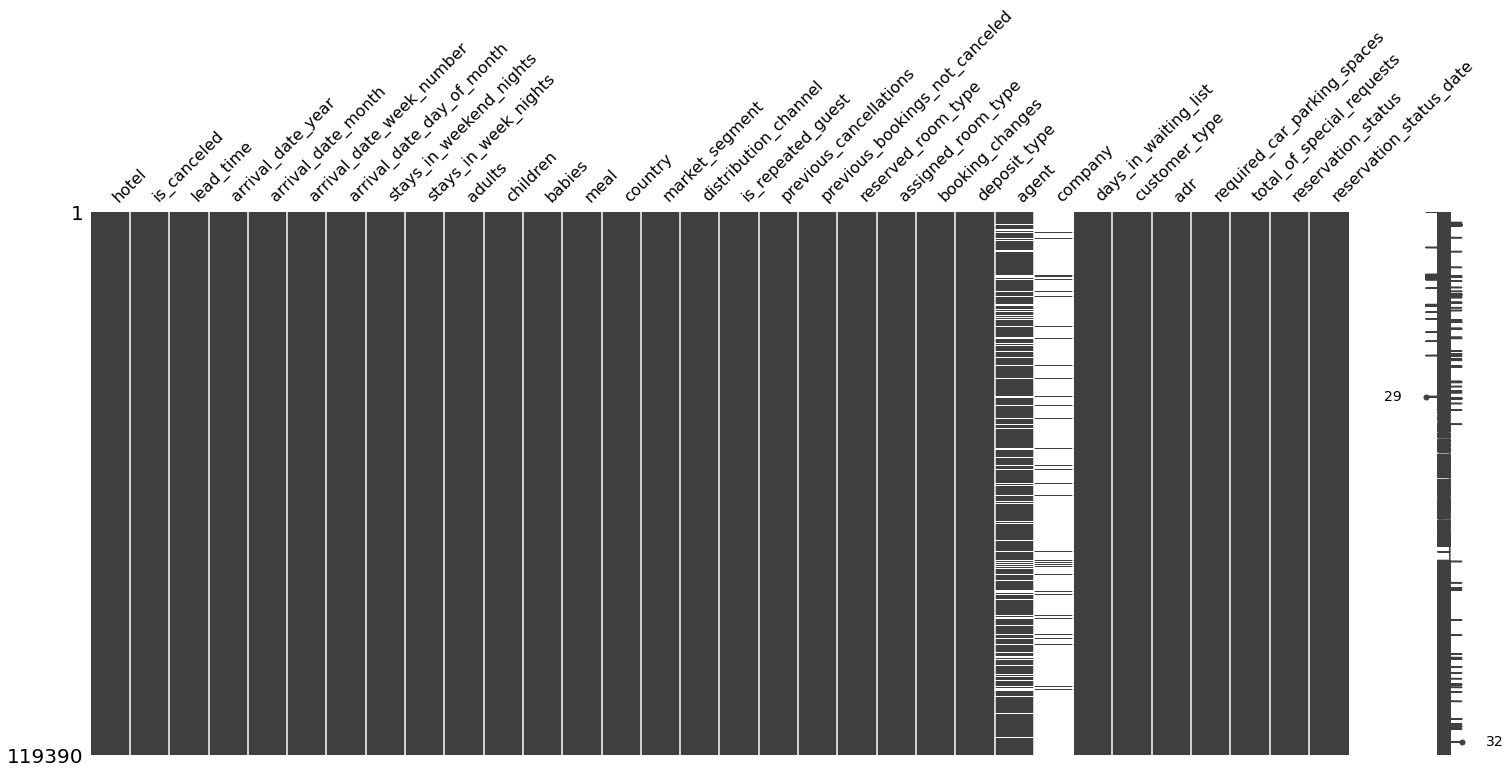

In [8]:
missingno.matrix(df)

<AxesSubplot:>

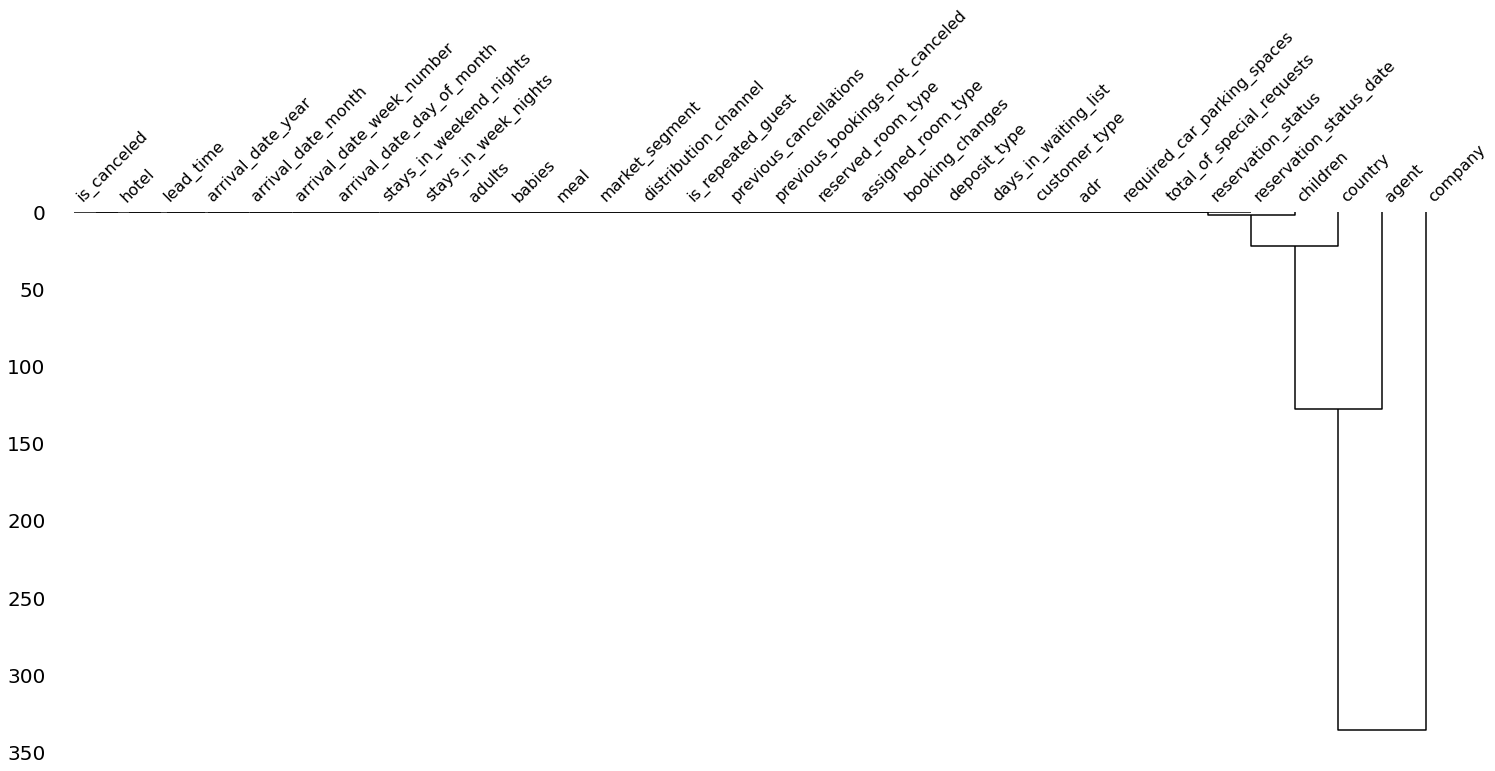

In [9]:
missingno.dendrogram(df)

terdapat missing value yang banyak di kolom agent dan company,missing value disini tidak terlihat saling berkorelasi. tetapi untuk analysis ini kami tidak menggunakan kolom-kolom tersebut karena selain missing value nya sangat banyak dan tidak berguna dalam anaylsis ini.

In [10]:
df.drop(columns=['company','agent','required_car_parking_spaces','adr','previous_bookings_not_canceled','assigned_room_type','arrival_date_week_number','stays_in_weekend_nights','stays_in_week_nights','arrival_date_day_of_month'],axis=1,inplace=True)

Terdapat kolom-kolom yang tidak digunakan karena tidak berfungsi untuk analysis dan modeling. Untuk kolom 'stays_in_weekend_nights','stays_in_week_nights','arrival_date_day_of_month' tidak sesuai dengan pengertian yang dimaksut seperti arrival date day of month yang nilai maximal nya mencapai 31 padahal dalam setahun hanya dalam 12 bulan. jika memang kolom tersebut dibutuhkan, bisa dibuat dari kolom resevation status date yang tersedia

In [11]:
df.dropna(inplace=True) # menghapus missing value pada children kolom terdiri dari 4 missing value

In [12]:
df['reservation_status_date']=pd.to_datetime(df.reservation_status_date)
df['children']=df['children'].astype(int)
# merubah tipe data sesuai dengan fungsi kolomnya

In [13]:
df.describe()

,is_canceled,lead_time,arrival_date_year,adults,children,babies,is_repeated_guest,previous_cancellations,booking_changes,days_in_waiting_list,total_of_special_requests
count,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000
mean,0.371352,104.311435,2016.157656,1.858391,0.104207,0.007948,0.032011,0.087142,0.221181,2.330754,0.571683
std,0.483168,106.903309,0.707459,0.578576,0.399172,0.097380,0.176029,0.845869,0.652785,17.630452,0.792678
min,0.000000,0.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,161.000000,2017.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,55.000000,10.000000,10.000000,1.000000,26.000000,21.000000,391.000000,5.000000


In [14]:
df.describe(include='object')

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,reservation_status
count,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898
unique,2,12,5,177,7,5,10,3,4,3
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,No Deposit,Transient,Check-Out
freq,79302,13852,91863,48586,56402,97730,85601,104163,89174,74745


In [15]:
df['arrival_date_day'] = df['reservation_status_date'].apply(lambda x: x.strftime('%d'))
df['arrival_date_day_name'] = df['reservation_status_date'].apply(lambda x: x.strftime('%A'))
df['arrival_date_day']=df['arrival_date_day'].astype(int)
# menambahkan kolom tanggal dan nama hari

In [16]:
df[df['distribution_channel']=='Undefined']
df.drop(index=[11380,14594],axis=0,inplace=True)

In [17]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,total_of_special_requests,reservation_status,reservation_status_date,arrival_date_day,arrival_date_day_name
0,Resort Hotel,0,342,2015,July,2,0,0,BB,PRT,Direct,Direct,0,0,C,3,No Deposit,0,Transient,0,Check-Out,2015-07-01,1,Wednesday
1,Resort Hotel,0,737,2015,July,2,0,0,BB,PRT,Direct,Direct,0,0,C,4,No Deposit,0,Transient,0,Check-Out,2015-07-01,1,Wednesday
2,Resort Hotel,0,7,2015,July,1,0,0,BB,GBR,Direct,Direct,0,0,A,0,No Deposit,0,Transient,0,Check-Out,2015-07-02,2,Thursday
3,Resort Hotel,0,13,2015,July,1,0,0,BB,GBR,Corporate,Corporate,0,0,A,0,No Deposit,0,Transient,0,Check-Out,2015-07-02,2,Thursday
4,Resort Hotel,0,14,2015,July,2,0,0,BB,GBR,Online TA,TA/TO,0,0,A,0,No Deposit,0,Transient,1,Check-Out,2015-07-03,3,Friday


Data sudah siap digunakan ke proses selanjutnya yaitu EDA, Business Insight dan Modelling. Setelah di cleaning data yang awalnya terdiri dari 119.390 rows dan 32 kolom menjadi 87.392 rows dan 29 kolom

## Data Distribution

In [18]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,total_of_special_requests,reservation_status,reservation_status_date,arrival_date_day,arrival_date_day_name
0,Resort Hotel,0,342,2015,July,2,0,0,BB,PRT,Direct,Direct,0,0,C,3,No Deposit,0,Transient,0,Check-Out,2015-07-01,1,Wednesday
1,Resort Hotel,0,737,2015,July,2,0,0,BB,PRT,Direct,Direct,0,0,C,4,No Deposit,0,Transient,0,Check-Out,2015-07-01,1,Wednesday
2,Resort Hotel,0,7,2015,July,1,0,0,BB,GBR,Direct,Direct,0,0,A,0,No Deposit,0,Transient,0,Check-Out,2015-07-02,2,Thursday
3,Resort Hotel,0,13,2015,July,1,0,0,BB,GBR,Corporate,Corporate,0,0,A,0,No Deposit,0,Transient,0,Check-Out,2015-07-02,2,Thursday
4,Resort Hotel,0,14,2015,July,2,0,0,BB,GBR,Online TA,TA/TO,0,0,A,0,No Deposit,0,Transient,1,Check-Out,2015-07-03,3,Friday


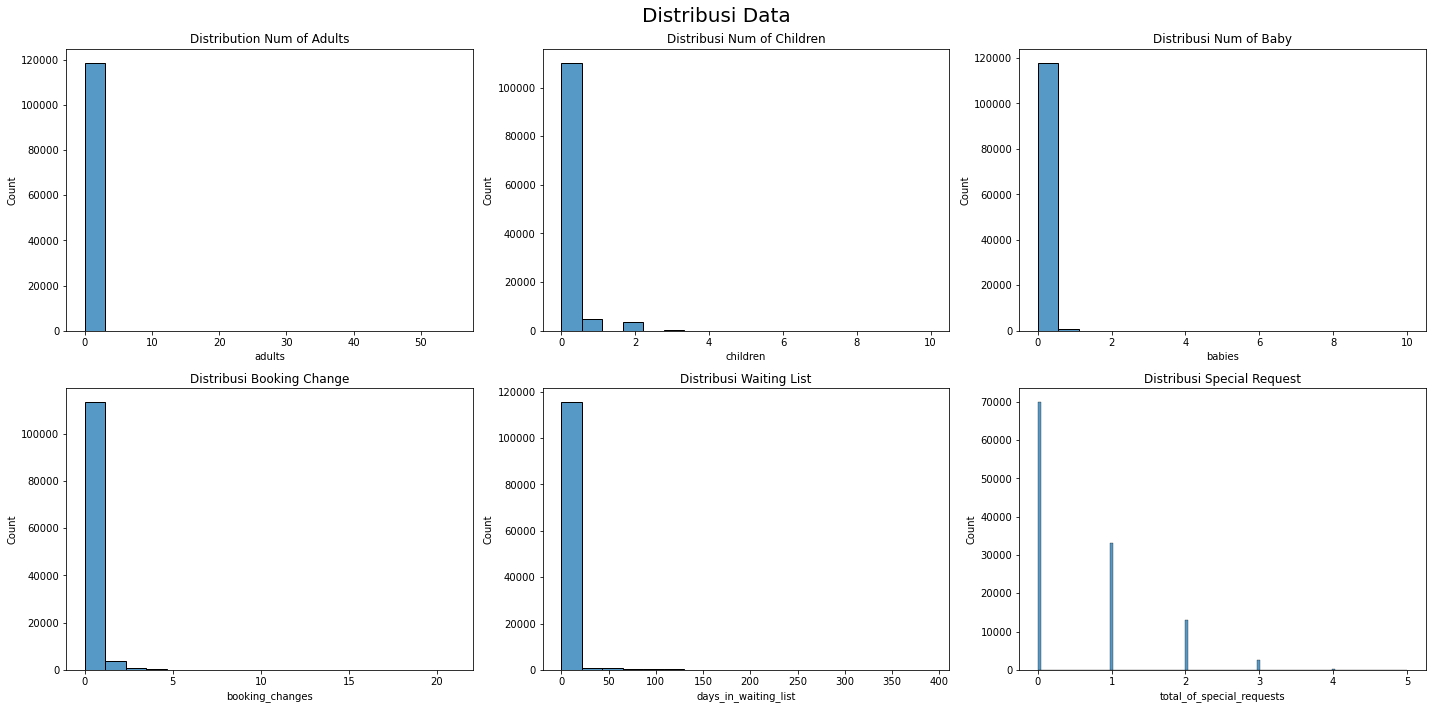

In [19]:
plt.figure(figsize=(20,10))
plt.suptitle('Distribusi Data',size=20)
plt.subplot(2,3,1)
sns.histplot(data=df['adults'])
plt.title('Distribution Num of Adults')

plt.subplot(2,3,2)
sns.histplot(data=df['children'])
plt.title('Distribusi Num of Children')

plt.subplot(2,3,3)
sns.histplot(data=df['babies'])
plt.title('Distribusi Num of Baby')
plt.tight_layout()

plt.subplot(2,3,4)
sns.histplot(data=df['booking_changes'])
plt.title('Distribusi Booking Change')
plt.tight_layout()

plt.subplot(2,3,5)
sns.histplot(data=df['days_in_waiting_list'])
plt.title('Distribusi Waiting List')
plt.tight_layout()

plt.subplot(2,3,6)
sns.histplot(data=df['total_of_special_requests'])
plt.title('Distribusi Special Request')
plt.tight_layout()

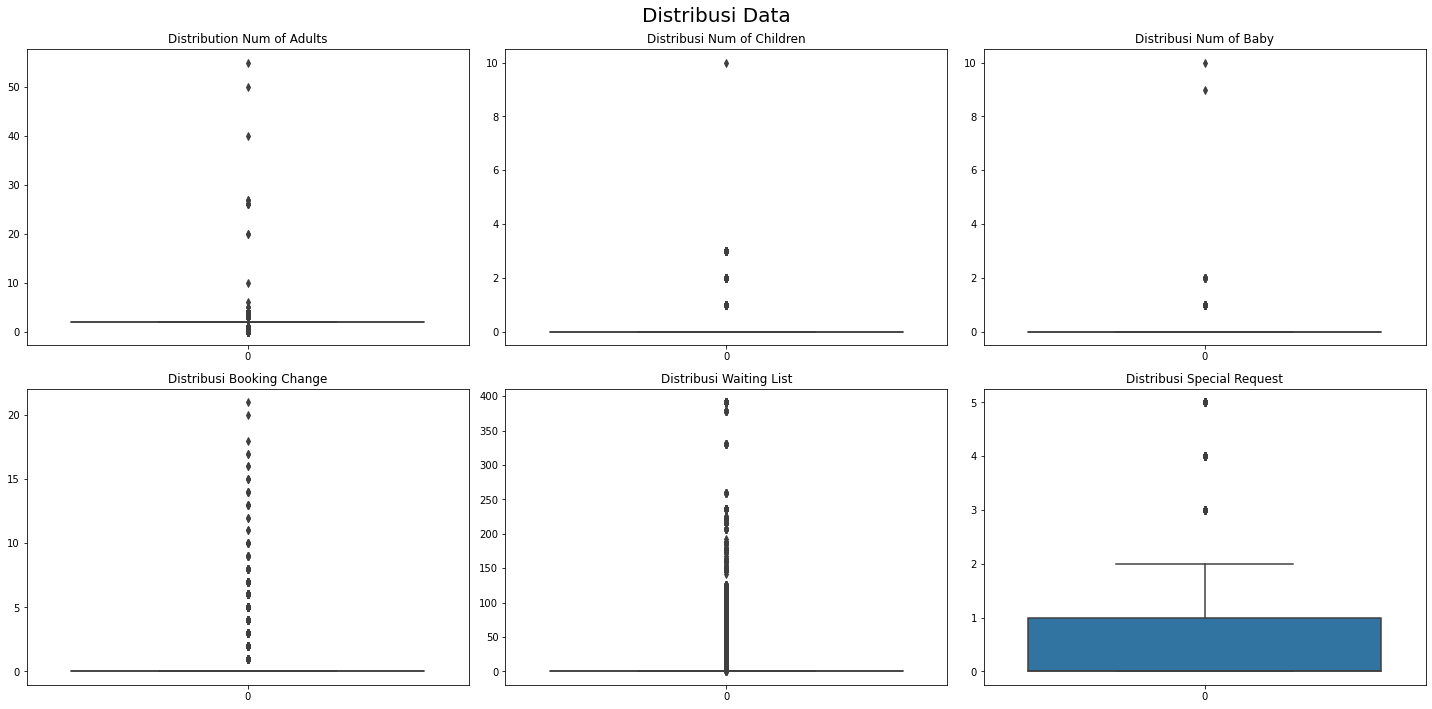

In [20]:
plt.figure(figsize=(20,10))
plt.suptitle('Distribusi Data',size=20)
plt.subplot(2,3,1)
sns.boxplot(data=df['adults'])
plt.title('Distribution Num of Adults')

plt.subplot(2,3,2)
sns.boxplot(data=df['children'])
plt.title('Distribusi Num of Children')

plt.subplot(2,3,3)
sns.boxplot(data=df['babies'])
plt.title('Distribusi Num of Baby')
plt.tight_layout()

plt.subplot(2,3,4)
sns.boxplot(data=df['booking_changes'])
plt.title('Distribusi Booking Change')
plt.tight_layout()

plt.subplot(2,3,5)
sns.boxplot(data=df['days_in_waiting_list'])
plt.title('Distribusi Waiting List')
plt.tight_layout()

plt.subplot(2,3,6)
sns.boxplot(data=df['total_of_special_requests'])
plt.title('Distribusi Special Request')
plt.tight_layout()

Dari seluruh data numerik di data ini terdapat banyak outlier. Distribusi dari kolom-kolom tersebut tidak normal sehingga untuk menentukan central tendency nya akan digunakan median

# Data Analysis
Data analysis yang dilakukan terhadap data ini adalah customer profiling dan customer behavior, untuk menengetahui karakteristik dari tamu yang menginap di hotel ini

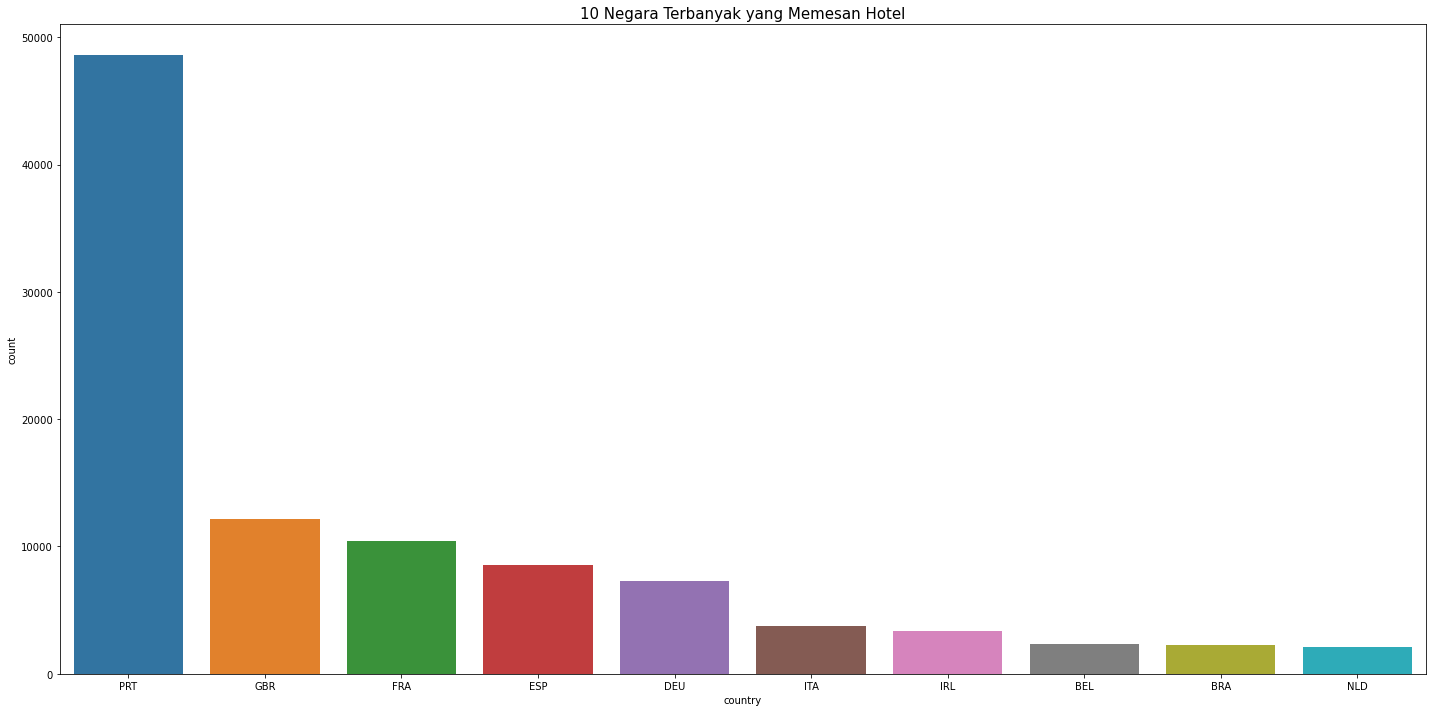

In [21]:
plt.figure(figsize=(20,10))
sns.countplot(x='country', data=df,
              order=df.country.value_counts().iloc[:10].index)
plt.title('10 Negara Terbanyak yang Memesan Hotel',size=15)


plt.tight_layout()

In [22]:
df['country'].value_counts(normalize=True)*100

PRT    40.862603
GBR    10.201352
FRA     8.759756
ESP     7.206298
DEU     6.128886
         ...    
DJI     0.000841
BWA     0.000841
HND     0.000841
VGB     0.000841
NAM     0.000841
Name: country, Length: 177, dtype: float64

**Darimana Tamu yang Paling Banyak Memesan Kamar Hotel?** Tamu yang paling banyak menginap di hotel berasal dari negara Portugal yang mencapai 40.86% diikuti Britania Raya 10.20% dan prancis 8.75%. Mayoritas tamu yang menginap dari portugal dan diikuti negara-negara eropa lainnya hal tersebut wajar karena hotel ini berada di lisbon ibukota portugal.

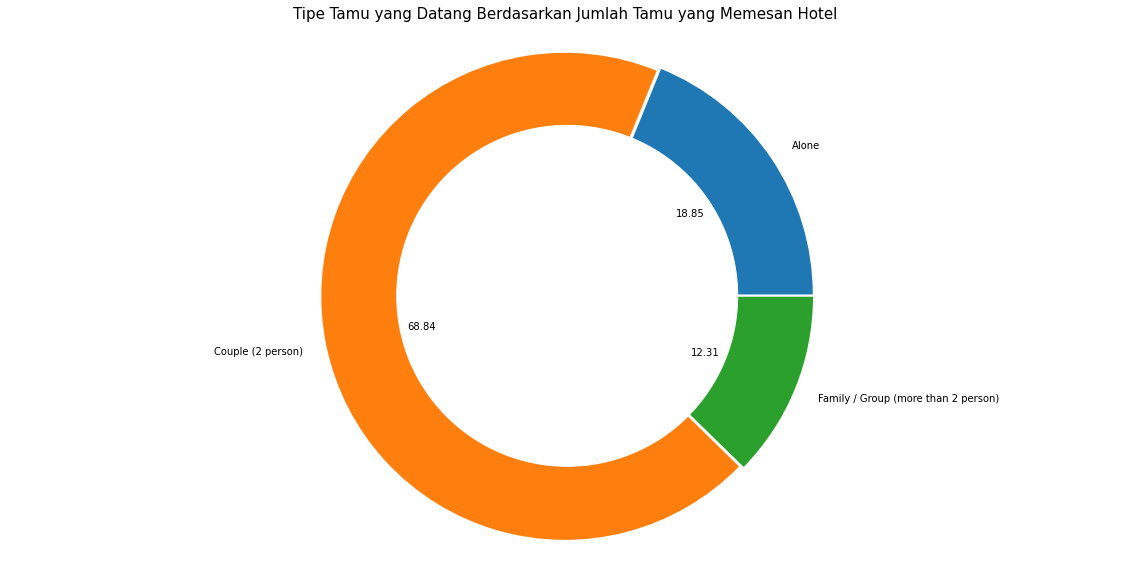

In [23]:
alone=df[(df['adults']==1)&(df['children']==0)&(df['babies']==0)]
couple=df[(df['adults']==2)&(df['children']==0)&(df['babies']==0)]
group=df[df['adults']+df['children']+df['babies']>2]

plt.figure(figsize=(20,10))
names = ['Alone', 'Couple (2 person)', 'Family / Group (more than 2 person)']
count = [alone.shape[0],couple.shape[0], group.shape[0]]

plt.pie(count,
        labels=names,
        autopct='%.2f',
        explode=(0.01,0.01,0.01)
)
plt.axis('equal')
my_circle = plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Tipe Tamu yang Datang Berdasarkan Jumlah Tamu yang Memesan Hotel',size=15)
plt.show()


**Siapa Tamu yang Paling Banyak Memesan Kamar Hotel?** Tamu yang datang paling banyak adalah couple atau terdiri dari 2 tamu yang mencapai 68.84%, yang datang sendiri sebanyak 18.85% dan yang datang group atau lebih dari 2 orang ada 12.31%. Dapat diasumsikan hotel ini bukan hotel untuk business trip ataupun hotel family vacation tetapi hotel untuk pasangan, tidak dapat dibuktikan karena tidak ada customer profiling dan profile dari hotel nya


<Figure size 1440x720 with 0 Axes>

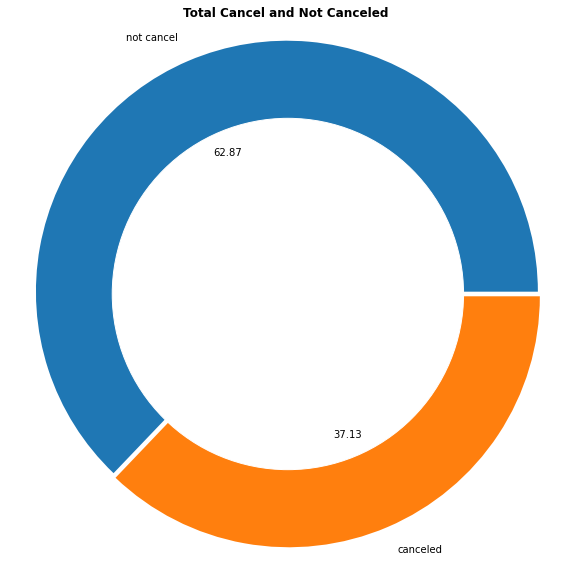

In [24]:
plt.figure(figsize=(20,10))
persen=list(df['is_canceled'].value_counts()/df.shape[0])
name= ['not cancel','canceled']

plt.figure(figsize=(10,10))
plt.pie(persen,
        labels=name,
        autopct='%.2f',
        explode=(0.01,0.01)
)
plt.axis('equal')
my_circle = plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Total Cancel and Not Canceled', weight='bold')
plt.show()

In [25]:
df['is_canceled'].value_counts()
# Target bisa dibilang imbalance

0    74744
1    44152
Name: is_canceled, dtype: int64

**Berapa Banyak Tamu yang Melakukan Pembatalan Pemesanan Hotel?** sebanyak 37.14 persen tamu yang memesan hotel melakukan pembatalan. Jumlah yang tergolong besar karena hampir dari setengah tamu yang memesan kamar hotel melakukan pembatalan. Hal ini yang menyebabkan pihak hotel ingin memiliki kemampuan memprediksi mana tamu yang akan cancel dan mana tamu yang tidak cancel

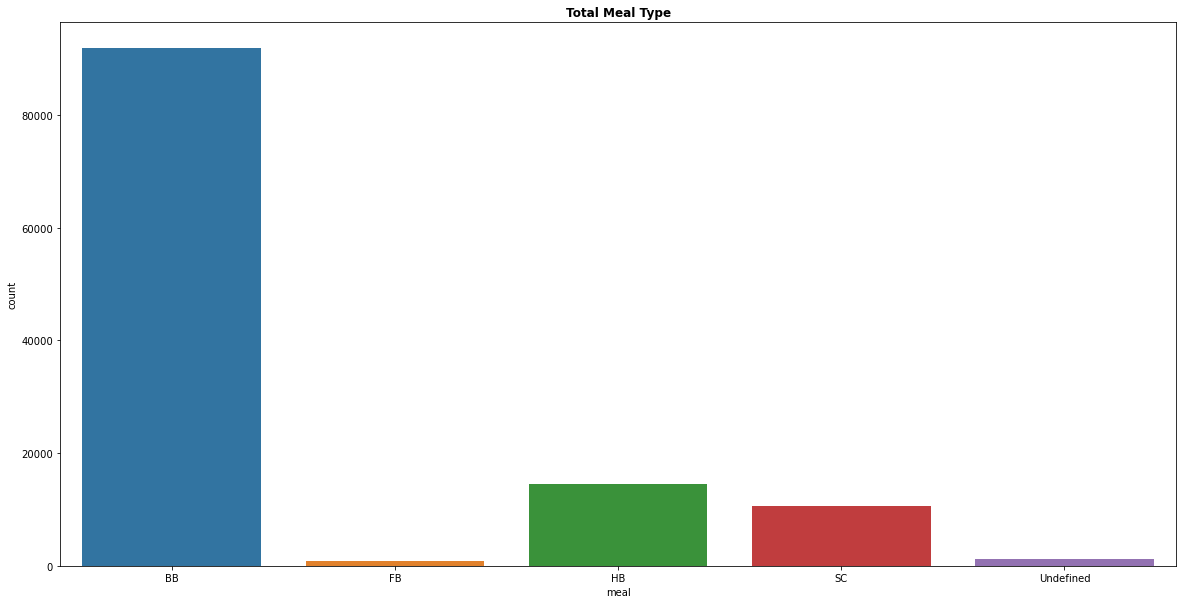

In [26]:
plt.figure(figsize=(20,10))
sns.countplot(x='meal',data=df)
plt.title('Total Meal Type', weight='bold')
plt.show()

**Apa paket kamar yang Paling Sering di Pesan Oleh Tamu Hotel?** Tamu yang datang paling suka memesan kamar beserta breakfast tanpa lunch dan dinner mencapai 68,36. Dapat diasumsikan hal tersebut wajar Karena jika dilihat dari *PieChart jenis tamu yang menginap adalah couple* dan bukan untuk bisnis ketika makan siang dan makan malam tamu lebih memilih makan diluar hotel mencari destinasi wisata kuliner.

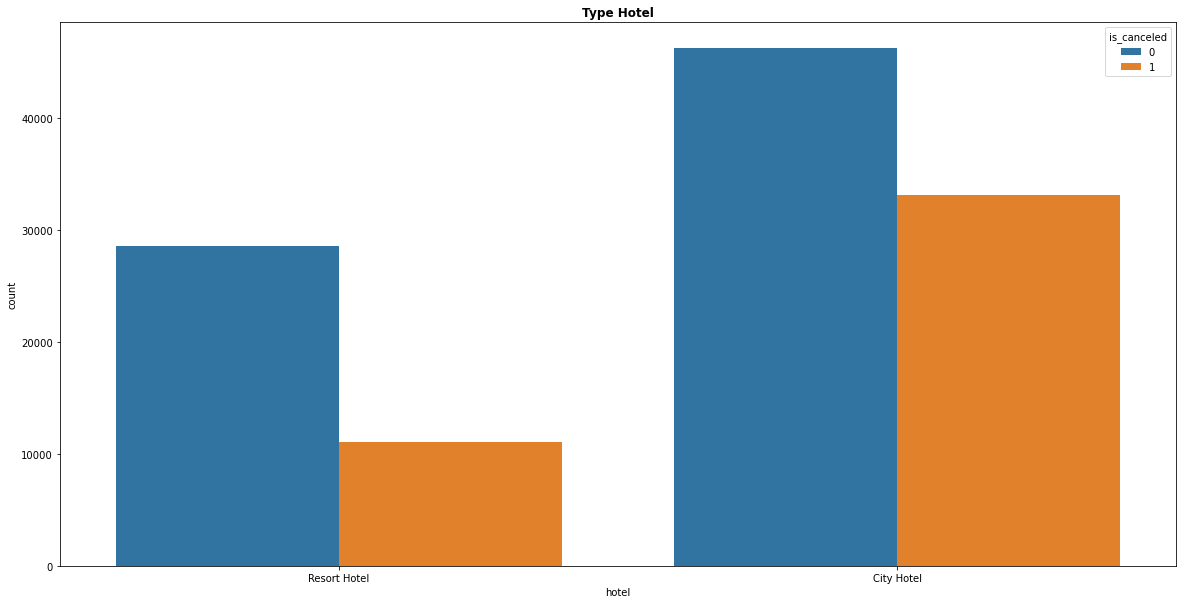

In [27]:
plt.figure(figsize=(20,10))
sns.countplot(x='hotel',data=df,hue='is_canceled') 
plt.title('Type Hotel', weight='bold')
plt.show()

In [28]:
df['hotel'].value_counts(normalize=True)*100

City Hotel      66.698627
Resort Hotel    33.301373
Name: hotel, dtype: float64

In [29]:
df[(df['hotel']=='City Hotel')&(df['is_canceled']==1)].shape[0]/df.shape[0]*100
# persentase tamu yang melakukan pemesanan di city hotel dan melakukan cancel booking

27.819270623065535

In [30]:
df[(df['hotel']=='Resort Hotel')&(df['is_canceled']==1)].shape[0]/df.shape[0]*100
# persentase tamu yang melakukan pemesanan di resort hotel dan melakukan cancel booking

9.315704481227291

**Dimana Hotel yang Paling Banyak di Pesan?** 66% hotel yang di pesan adalah city hotel, 27% tamu yang booking melakukan cancel, sedangkan untuk resort hotel dari 33.30%, 9% tamu nya melakukan cancel booking

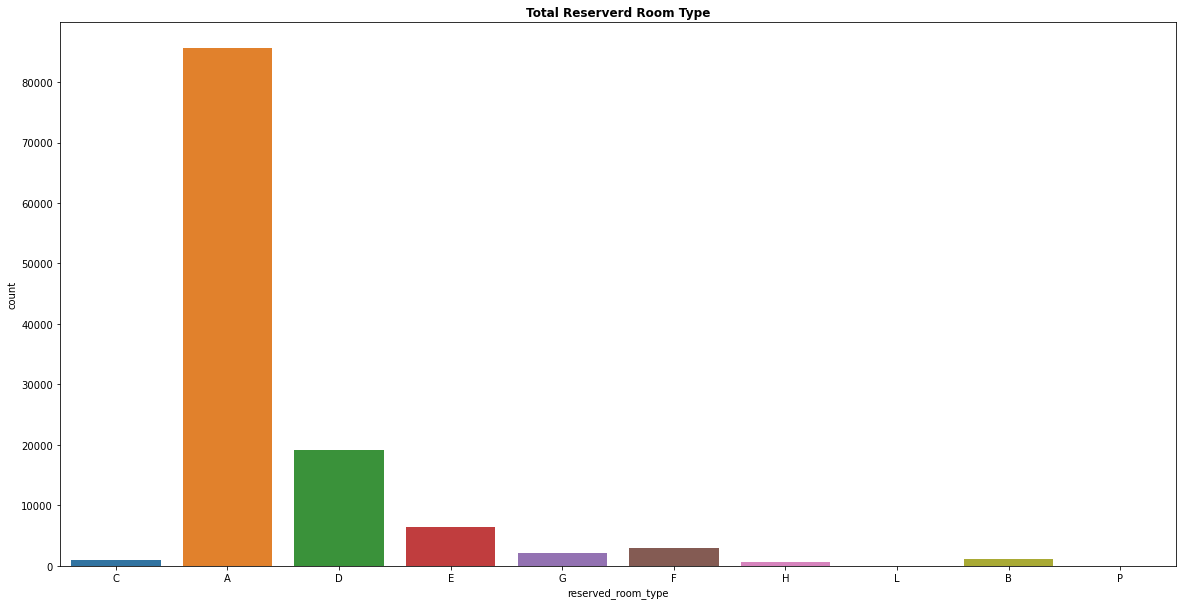

In [31]:
plt.figure(figsize=(20,10))
sns.countplot(x='reserved_room_type',data=df)
plt.title('Total Reserverd Room Type', weight='bold')
plt.show()

In [32]:
df['reserved_room_type'].value_counts(normalize=True)*100

A    71.995694
D    16.125858
E     5.464440
F     2.429855
G     1.751951
B     0.936953
C     0.783037
H     0.505484
L     0.005046
P     0.001682
Name: reserved_room_type, dtype: float64

**Apa Tipe Kamar yang Paling Banyak di Pesan Oleh Tamu Hotel?** Tipe kamar yang paling sering di datangi adalah tipe A mencapai 72% diikuti dengan tipe kamar D 16,12% dan tipe kamar E 5.46%

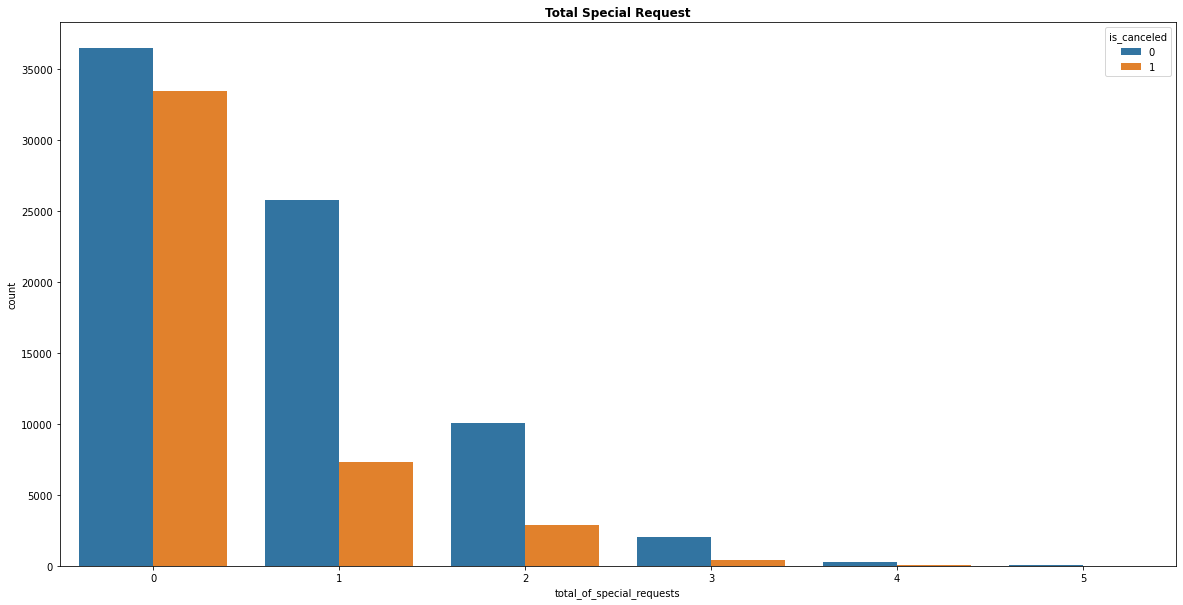

In [33]:
plt.figure(figsize=(20,10))
sns.countplot(x='total_of_special_requests',hue='is_canceled',data=df)
plt.title('Total Special Request', weight='bold')
plt.show()

In [34]:
df['total_of_special_requests'].value_counts()/df.shape[0]

0    0.588666
1    0.278571
2    0.108675
3    0.020917
4    0.002851
5    0.000320
Name: total_of_special_requests, dtype: float64

In [35]:
df[(df['total_of_special_requests']==0)&(df['is_canceled']==1)].shape[0]/df.shape[0]

0.28175884806890056

**Berapa Banyak Tamu yang Meminta Permintaan Khusus Dari Hotel?** mayoritas tamu (58,88%) yang memesan kamar hotel tidak memiliki permintaan khusus kepada hotel. Dari Barplot diatas dapat dilihat bahwah 28% tamu yang memesan kamar hotel tanpa memiliki permintaan khusus kepada hotel melakukan pembatalan

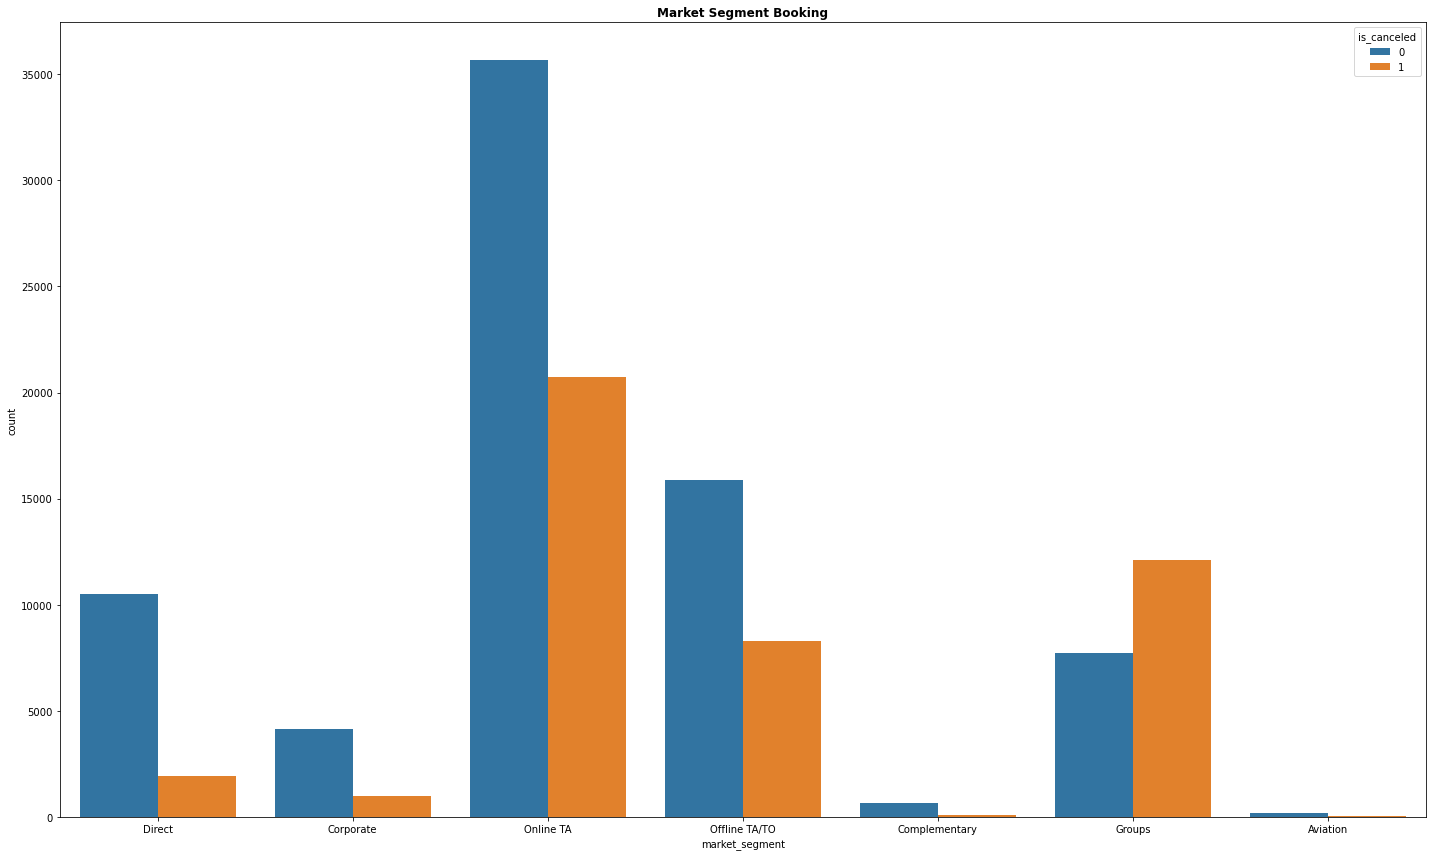

In [36]:
plt.figure(figsize=(20,12))
sns.countplot(x='market_segment',hue='is_canceled', data=df)
plt.title('Market Segment Booking', weight='bold')
plt.tight_layout()

In [37]:
df['market_segment'].value_counts(normalize=True)*100

Online TA        47.437256
Offline TA/TO    20.320280
Groups           16.658256
Direct           10.468813
Corporate         4.298715
Complementary     0.617346
Aviation          0.199334
Name: market_segment, dtype: float64

In [38]:
df[(df['market_segment']=='Online TA')&(df['is_canceled']==1)].shape[0]/df.shape[0]*100

17.441293231059078

In [39]:
df[(df['market_segment']=='Offline TA/TO')&(df['is_canceled']==1)].shape[0]/df.shape[0]*100

6.962387296460773

In [40]:
df[(df['market_segment']=='Groups')&(df['is_canceled']==1)].shape[0]/df.shape[0]*100

10.174438164446238

In [41]:
df[(df['market_segment']=='Direct')&(df['is_canceled']==1)].shape[0]/df.shape[0]*100

1.6148566814695196

In [79]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,total_of_special_requests,reservation_status,reservation_status_date,arrival_date_day,arrival_date_day_name
0,Resort Hotel,0,342,2015,July,2,0,0,BB,PRT,Direct,Direct,0,0,C,3,No Deposit,0,Transient,0,Check-Out,2015-07-01,1,Wednesday
1,Resort Hotel,0,737,2015,July,2,0,0,BB,PRT,Direct,Direct,0,0,C,4,No Deposit,0,Transient,0,Check-Out,2015-07-01,1,Wednesday
2,Resort Hotel,0,7,2015,July,1,0,0,BB,GBR,Direct,Direct,0,0,A,0,No Deposit,0,Transient,0,Check-Out,2015-07-02,2,Thursday
3,Resort Hotel,0,13,2015,July,1,0,0,BB,GBR,Corporate,Corporate,0,0,A,0,No Deposit,0,Transient,0,Check-Out,2015-07-02,2,Thursday
4,Resort Hotel,0,14,2015,July,2,0,0,BB,GBR,Online TA,TA/TO,0,0,A,0,No Deposit,0,Transient,1,Check-Out,2015-07-03,3,Friday


**Darimana Tamu Melakukan Pemesanan Kamar Hotel Dengan Pembatalan Terbanyak?** Dari 47,43% Tamu yang memesan kamar hotel melalui Online Travel Agent, 17.44% diantaranya melakukan pembatalan sedangkan dari 20.31% Tamu yang memesan kamar hotel dengan offline TA/TO 6.96% nya melakukan pembatalan. Dari 16.65% pesanan melalui Groups 10.17% nya melakukan cancel, dan dari 10.46% melakukan pemesanan langsung hanya 1.61% nya melakukan cancel

bisa kita lihat bahwa lebih dari 50% pemesanan melalui group melakukan cancel, harus dicari penyebabnya mengapa hal tersebut terjadi

In [88]:
df_cancel=df[df['is_canceled']==1].copy()

In [90]:
day_hour=df_cancel.groupby(['arrival_date_day_name','arrival_date_month']).agg({'is_canceled':'count'}).rename(columns={'is_canceled':'freq'}).reset_index()
day_hour['arrival_date_day_name']=pd.Categorical(day_hour['arrival_date_day_name'],categories=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],ordered=True)
day_hour['arrival_date_month']=pd.Categorical(day_hour['arrival_date_month'],categories=['January','February','March','April','May','June','July','August','September','October','November','December'],ordered=True)
day_hour=day_hour.pivot('arrival_date_day_name','arrival_date_month','freq')

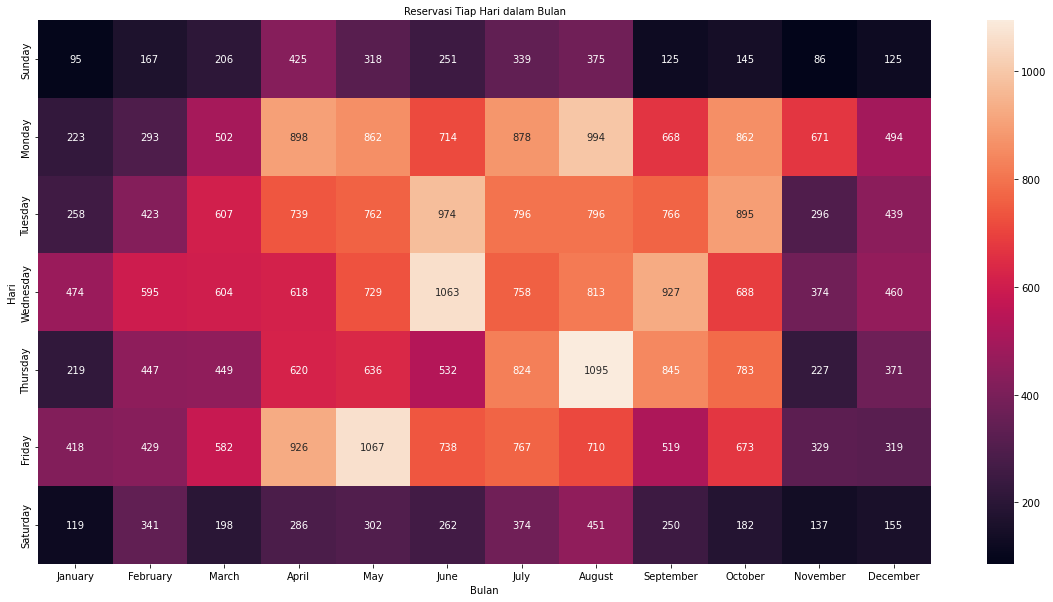

In [91]:
plt.figure(figsize=(20,10))
ax=sns.heatmap(day_hour,annot=True,fmt="d")
ax.set_xlabel("Bulan")
ax.set_ylabel("Hari")
ax.set_title("Reservasi Tiap Hari dalam Bulan",size=10)
plt.show()

**Kapan Traffic Pembatalan Pemesanan Hotel Teramai?** dari heatmap diatas terlihat bahwa tamu paling banyak melakukan cancel kamar di bulan april sampai dengan agustus dan di hari weekdays. hal tersebut wajar memungkinkan pemesanan yang dilakukan untuk penginapan di hari weekend

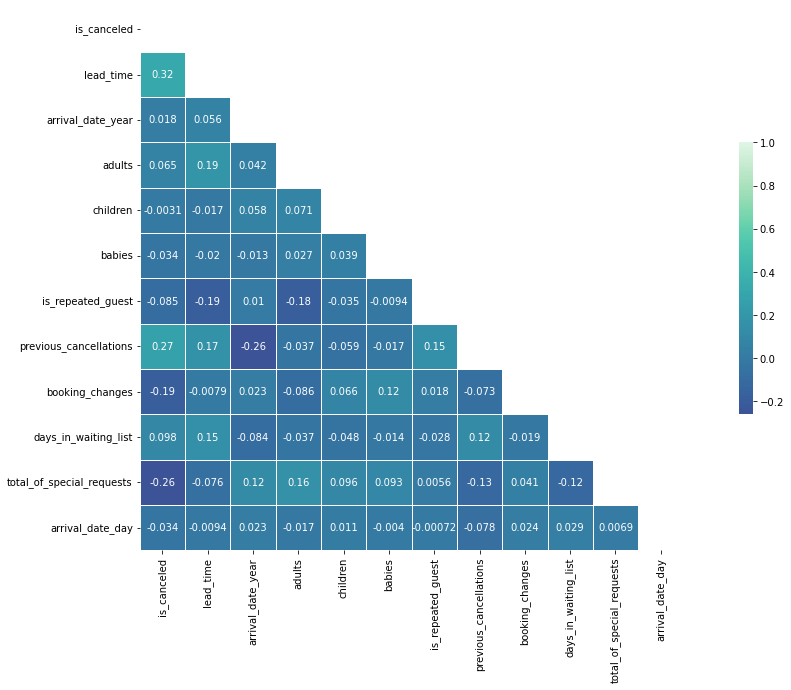

In [44]:
plt.figure(figsize=(20,10))
mask = np.triu(np.ones_like(df.corr(method='spearman'), dtype=bool))


sns.heatmap(df.corr(method='spearman'), mask=mask,cmap='mako',annot=True, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Tiap kolom numerical nya terlihat korelasi nya cukup rendah

# Data Preprocessing

Numerical Data : Robust Scaler karena memiliki banyak outlier (Logreg)

onehot encoding : distribution channel, deposite_type, costumer_type

binary encoding : meal, country, market_segment, reserved_room_type


In [45]:
transformer=ColumnTransformer([
    ('onehot',OneHotEncoder(drop='first'),['distribution_channel','deposit_type','customer_type','hotel']),
    ('binary',ce.BinaryEncoder(),['meal','country','market_segment','reserved_room_type','hotel'])
],remainder='passthrough')

In [46]:
transformer2=ColumnTransformer([
    ('onehot',OneHotEncoder(drop='first'),['distribution_channel','deposit_type','customer_type','hotel']),
    ('binary',ce.BinaryEncoder(),['meal','country','market_segment','reserved_room_type']),
    ('scaler',RobustScaler(),['adults','days_in_waiting_list','babies','children','booking_changes'])
],remainder='passthrough')

# transformer 2 dipergunakan untuk model logreg karena data numeriknya di scaling

## Splitting Data

In [48]:
x=df[['distribution_channel','deposit_type','customer_type','meal','country','market_segment','reserved_room_type','adults','days_in_waiting_list','children','babies','booking_changes','total_of_special_requests','hotel','lead_time']]
y=df['is_canceled']

In [49]:
x_train,x_test,y_train,y_test= train_test_split(x,y,stratify=y,test_size=0.2,random_state=2020)

# Model Benchmark

Model memprediksi user akan *cancel booking* (membatalkan pesanan), padahal sebenarnya/realisasinya user tidak membatalkan pesanan. **FP**

kerugian yang didapat ketika kita mengabaikan **FP** : 
* dapat merugikan hotel karena bisa dilihat dari data analysis diatas ketika kita memprediksi user akan cancel booking, padahal realitanya user tidak cancel, akan membuat customer merasa dirugikan dan hotel akan kehilangan customer
* dari barplot market segment diatas, 47,43% customer memesan kamar hotel melalui online travel agent, dan yang sudah kita ketahui ketika kita memesan kamar di online travel agent akan ada rating yang diberikan oleh customer kepada hotel. Ketika customer yang kita prediksi merasa dirugikan memberikan rating yang buruk, akan berdampak pada rating hotel di suatu online travel agent dan dapat menurunkan minat customer lain untuk memesan hotel

Model memprediksi user tidak membatalkan pesanan, padahal sebenarnya/realisasinya user *cancel booking* (membatalkan pesanan).            **FN**

kerugian yang didapat ketika mengabaikan **FN**:
* kerugian pada FP bisa dilihat dari benefit dan persiapan yang kita berikan ketika tamu diprediksi tidak cancel booking. mulai dari layanan penjemputan jika diperlukan, makan dan minum yang sudah disiapkan dan yang paling merugikan adalah ketika ternyata pengunjung yang diprediksi tidak cancel dan aktual nya cancel, hotel akan rugi karena tidak bisa menyewakan kamar hotel tersebut. 

Scoring yang dipilih adalah f1 score karena kedua kelas tersebut sama-sama dapat memberikan kerugian yang sama besar untuk hotel 

In [50]:
from imblearn.pipeline import Pipeline
smote= SMOTE(random_state=2020, k_neighbors=5)
pipe_tree=Pipeline([
    ('preprocess',transformer),
    ('smote',smote),
    ('model',DecisionTreeClassifier(max_depth=5))
])

pipe_logreg=Pipeline([
    ('preprocess',transformer2),
    ('smote',smote),
    ('model',LogisticRegression(max_iter=1000))
])

pipe_knn=Pipeline([
    ('preprocess',transformer),
    ('smote',smote),
    ('model',KNeighborsClassifier())
])

pipe_forest=Pipeline([
    ('preprocess',transformer),
    ('smote',smote),
    ('model',RandomForestClassifier(max_depth=5))
])

models=[pipe_tree,pipe_logreg,pipe_knn,pipe_forest]
score=[]
mean=[]
std=[]

for i in models:
    model_cv= cross_val_score(i,x_train,y_train,error_score='raise',scoring='f1')
    score.append(model_cv)
    mean.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({
    'model':['tree','logreg','knn','forest'],
    'mean':mean,
    'std':std
})

C:\Users\RynPyCua\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model,mean,std
0,tree,0.695812,0.006098
1,logreg,0.696025,0.001257
2,knn,0.732451,0.004408
3,forest,0.739677,0.004412


In [51]:
nearmiss= NearMiss(n_neighbors=5)
pipe_tree=Pipeline([
    ('preprocess',transformer),
    ('nearmiss',nearmiss),
    ('model',DecisionTreeClassifier(max_depth=5))
])

pipe_logreg=Pipeline([
    ('preprocess',transformer2),
    ('nearmiss',nearmiss),
    ('model',LogisticRegression(max_iter=1000))
])

pipe_knn=Pipeline([
    ('preprocess',transformer),
    ('nearmiss',nearmiss),
    ('model',KNeighborsClassifier())
])

pipe_forest=Pipeline([
    ('preprocess',transformer),
    ('nearmiss',nearmiss),
    ('model',RandomForestClassifier(max_depth=5))
])

models=[pipe_tree,pipe_logreg,pipe_knn,pipe_forest]
score=[]
mean=[]
std=[]

for i in models:
    model_cv= cross_val_score(i,x_train,y_train,error_score='raise',scoring='f1')
    score.append(model_cv)
    mean.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({
    'model':['tree','logreg','knn','forest'],
    'mean':mean,
    'std':std
})

C:\Users\RynPyCua\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model,mean,std
0,tree,0.655423,0.014106
1,logreg,0.644804,0.003626
2,knn,0.682124,0.001569
3,forest,0.696724,0.002590


In [52]:
pipe_tree=Pipeline([
    ('preprocess',transformer),
    ('model',DecisionTreeClassifier(max_depth=5))
])

pipe_logreg=Pipeline([
    ('preprocess',transformer2),
    ('model',LogisticRegression(max_iter=1000))
])

pipe_knn=Pipeline([
    ('preprocess',transformer),
    ('model',KNeighborsClassifier())
])

pipe_forest=Pipeline([
    ('preprocess',transformer),
    ('model',RandomForestClassifier(max_depth=5))
])

models=[pipe_tree,pipe_logreg,pipe_knn,pipe_forest]
score=[]
mean=[]
std=[]

for i in models:
    model_cv= cross_val_score(i,x_train,y_train,error_score='raise',scoring='f1')
    score.append(model_cv)
    mean.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({
    'model':['tree','logreg','knn','forest'],
    'mean':mean,
    'std':std
})

,model,mean,std
0,tree,0.663336,0.002870
1,logreg,0.671093,0.002061
2,knn,0.729398,0.004314
3,forest,0.581700,0.011173


Karena perbandingan antara target kelas 1 dan 0 nya tidak seimbang, dilakukan 3 tipe cross validasi yang berbeda pertama menggunakan balancing SMOTE, yang kedua menggunakan balancing Nearmiss, dan yang terakhir tanpa balancing

# Model Performance with Data Test

In [53]:
# Model KNN Without Balancing
knn=KNeighborsClassifier()
estimator=Pipeline([
    ('preprocess',transformer),
    ('model',knn)
])
estimator.fit(x_train, y_train)
y_pred=estimator.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     14949
           1       0.75      0.71      0.73      8831

    accuracy                           0.81     23780
   macro avg       0.79      0.79      0.79     23780
weighted avg       0.81      0.81      0.81     23780



In [54]:
# Model Forest With SMOTE
forest=RandomForestClassifier(max_depth=5)
smote= SMOTE(random_state=2020, k_neighbors=5)
estimator=Pipeline([
    ('preprocess',transformer),
    ('smote',smote),
    ('model',forest)
])

estimator.fit(x_train, y_train)
y_pred=estimator.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85     14949
           1       0.77      0.71      0.74      8831

    accuracy                           0.81     23780
   macro avg       0.80      0.79      0.80     23780
weighted avg       0.81      0.81      0.81     23780



Dari hasil prediksi menggunakan data test, random forest memiliki nilai f1 score lebih tinggi dari KNN walaupun sedikit. Karena itu kita akan melanjutkan melihat feature importance dan melakukan tunning menggunakan model random forest

In [55]:
estimator[0].transformers_[0][1].get_feature_names_out()

array(['distribution_channel_Direct', 'distribution_channel_GDS',
       'distribution_channel_TA/TO', 'deposit_type_Non Refund',
       'deposit_type_Refundable', 'customer_type_Group',
       'customer_type_Transient', 'customer_type_Transient-Party',
       'hotel_Resort Hotel'], dtype=object)

In [56]:
estimator[0].transformers_[1][1].get_feature_names()

['meal_0',
 'meal_1',
 'meal_2',
 'country_0',
 'country_1',
 'country_2',
 'country_3',
 'country_4',
 'country_5',
 'country_6',
 'country_7',
 'market_segment_0',
 'market_segment_1',
 'market_segment_2',
 'reserved_room_type_0',
 'reserved_room_type_1',
 'reserved_room_type_2',
 'reserved_room_type_3',
 'hotel_0',
 'hotel_1']

In [59]:
list(x.describe().columns)

['adults',
 'days_in_waiting_list',
 'children',
 'babies',
 'booking_changes',
 'total_of_special_requests',
 'lead_time']

In [61]:
features=list(estimator[0].transformers_[0][1].get_feature_names_out()) + estimator[0].transformers_[1][1].get_feature_names() + list(x.describe().columns)

<AxesSubplot:>

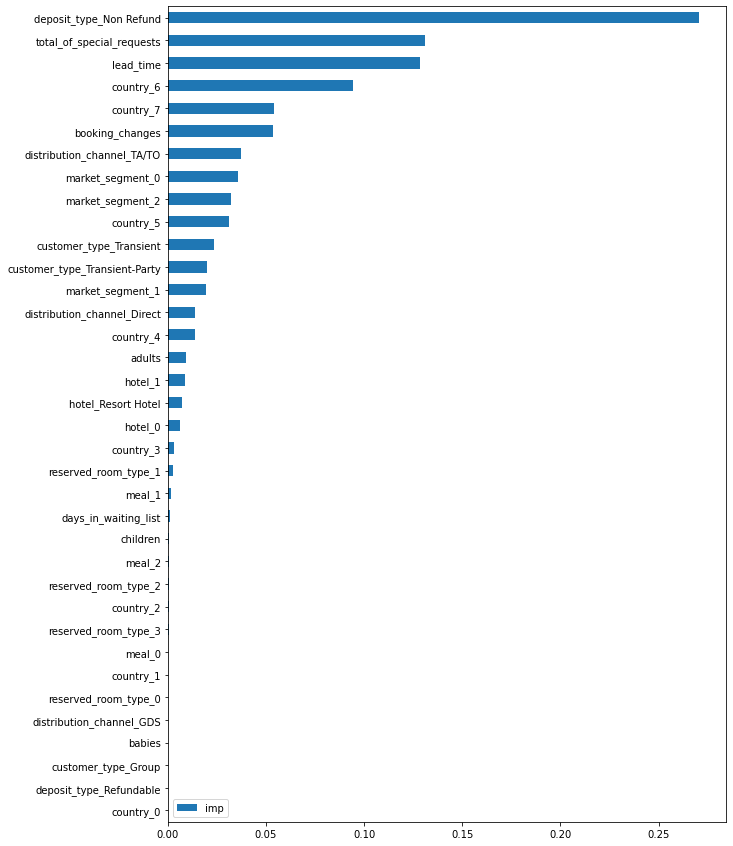

In [62]:
pd.DataFrame({
    'imp': forest.feature_importances_}, index=features).sort_values('imp').plot(kind='barh',figsize=(10,15))

# Hyperparameter Tunning

In [64]:
forest=RandomForestClassifier(max_depth=5)
smote= SMOTE(random_state=2020, k_neighbors=5)
estimator=Pipeline([
    ('preprocess',transformer),
    ('smote',smote),
    ('model',forest)
])

In [65]:
estimator.get_params()

{'memory': None,
 'steps': [('preprocess',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehot', OneHotEncoder(drop='first'),
                                    ['distribution_channel', 'deposit_type',
                                     'customer_type', 'hotel']),
                                   ('binary', BinaryEncoder(),
                                    ['meal', 'country', 'market_segment',
                                     'reserved_room_type', 'hotel'])])),
  ('smote', SMOTE(random_state=2020)),
  ('model', RandomForestClassifier(max_depth=5))],
 'verbose': False,
 'preprocess': ColumnTransformer(remainder='passthrough',
                   transformers=[('onehot', OneHotEncoder(drop='first'),
                                  ['distribution_channel', 'deposit_type',
                                   'customer_type', 'hotel']),
                                 ('binary', BinaryEncoder(),
                                  ['meal', 'c

In [66]:
hyperparam_space={
    'model__n_estimators': range(5,45,10),
    'model__max_depth':range(2,8)
}

In [68]:
skfold=StratifiedKFold(n_splits=5)
grid_search= GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv=skfold,
    scoring='f1'
)

In [69]:
grid_search.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['distribution_channel',
                                                                          'deposit_type',
                                                                          'customer_type',
                                                                          'hotel']),
                                                                        ('binary',
                                                                         BinaryEncoder(),
                                                              

In [70]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'model__max_depth': 7, 'model__n_estimators': 35}
0.7474182714134929


# Before After Tunning

In [71]:
# Before
forest=RandomForestClassifier(max_depth=5)
smote= SMOTE(random_state=2020, k_neighbors=5)
estimator=Pipeline([
    ('preprocess',transformer),
    ('smote',smote),
    ('model',forest)
])

estimator.fit(x_train, y_train)
y_pred=estimator.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85     14949
           1       0.77      0.71      0.74      8831

    accuracy                           0.81     23780
   macro avg       0.80      0.79      0.80     23780
weighted avg       0.81      0.81      0.81     23780



In [72]:
# after
best_model=grid_search.best_estimator_
best_model.fit(x_train,y_train)
y_pred=best_model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86     14949
           1       0.77      0.72      0.74      8831

    accuracy                           0.81     23780
   macro avg       0.80      0.80      0.80     23780
weighted avg       0.81      0.81      0.81     23780



Hasil dari after tunning nya tidak memberikan impact yang signifikan. jadi kita gunakan yang before tunning saja karena model lebih ringan

# Conclusion

**Model Impact**

Model yang dipiliah adalah random forest. Didasari dari model tree, random forest memiliki keunggulan menjadi model yang lebih stabil karena melakukan atau membuat pohon keputusan sesuai dengan n estimator yang sudah kita tentukan, dari percobaan pohon keputusan berulang dengan feature yang berbeda lalu score nya diambil dari penilaian seluruh pohon yang dibuat. Upaya yang telah dilakukan untuk membuat model menjadi lebih baik dilakukanlah tunning dengan memasukan params grid maxdepth untuk menentukan sebarapa dalam pohon kita, min samples leaf untuk menentukan berapa minimum samples yang ada di daun pohon keputusan, dan min sample split untuk menentukan minimum sample sebelum suatu leaf di split kembali, tetapi hasil tidak berubah signikfikan karena itu cukup menggunakan model benchmark yang sudah kita tentukan.

 dari analysis dan visualisasi barplot berdasarkan kolom is_canceled, 37,13% tamu melakukan cancel terhadap pemesanannya. berarti 44.152 orang yang melakukan pembatalan pesanan, jika menggunakan metrics f1 dengan score 74%, maka 26% dari tamu `datang/tidak cancel` tetapi diprediksi cancel, dengan market segment online TA sekitar 30.912 orang yang kemungkinan memberikan rating buruk terhadap hotel karena ketika dia tiba dihotel padahal sudah di prediksi akan melakukan cancel.

Jika diasumsikan kamar di hotel ini adalah 1jt per malam, mungkin hotel bisa dibilang rugi 44.152.000.000 karena kamar tersebut gagal di gunakan padahal sudah dibooking, saat suatu kamar di booking hotel tentu tidak dapat menyewakan kamar tersebut ke tamu lainnya. jika menggunakan model dari metrics f1 score ini, 26% tamu yang diprediksi tidak cancel actualnya cancel maka kita dapat mengurangi kerugian dari gagal nya penyewaan kamar menjadi 30.912.000.000. menurut kami hal tersebut sudah cukup baik karena dapat mengurangi kerugian hotel sebanyak 14 milyar.

* FP dapat merugikan hotel walaupun dampak yang di dapat tidak langsung, tetapi akan berdampak besar di masa yang akan datang karena customer yang dirugikan mungkin tidak akan memesan hotel ini, dan jika mengabaikan FP akan membuat rating buruk di online travel agent yang sudah menjadi market segment terbesar di hotel ini. Sedangkan FN berdampak langsung bagi hotel, bisa dihitung kerugian dari FN mencapai 30M. 

**Recomendation**

* Saya merekomendasikan hotel untuk menggunakan model ini karena bisa mengurangi 14ribu orang yang melakukan cancel, jika diasumsikan kamar 1 malam adalah 1jt, maka model ini mampu mengurangi kerugian sebanyak 14M, tetapi untuk meminimalisir FN yaitu tamu yang di prediksi tidak cancel tetapi aktual nya cancel bisa meninjau perjanjian kerja sama dengan travel agent baik itu Online atau Offline dimana sudah menjadi market segment terbesar dari hotel ini untuk menentukan batas minimum hari sebelum melakukan cancel, sehingga hotel dapat menyewakan kamar yang tidak jadi disewa.

* Dan Untuk mengurangi FP atau tamu yang diprediksi cancel tetapi aktualnya tidak, tim customer service bisa menelfon atau melakukan whatsapp untuk mengkonfirmasi kedatangan sehingga dapat mengurangi kemungkinan mengecewakan tamu yang benar benar akan datang sehingga membuat rating hotel tetap baik.





